## 1. 사용할 패키지 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/kmong/car_number'

/content/drive/MyDrive/kmong/car_number


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/kmong/car_number/data_gen')

In [ ]:
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import json
from data_gen.data_gen import PointInferenceDatasetGenerator, ClassInferenceDatasetGenerator
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## 2. 데이터 불러오기

### (1) Inference Data 경로 지정

In [ ]:
inference_img_path = "/content/drive/MyDrive/kmong/car_number/dataset/test/img"

### (2) Inference Data 불러오기

In [ ]:
inference_img_list = os.listdir(inference_img_path)
inference_img_list = sorted(inference_img_list)
inference_img_list = [os.path.join(inference_img_path, img) for img in inference_img_list]

## 3. 모델링

In [ ]:
save_path = "/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference"
os.makedirs(save_path, exist_ok=True)

### (1) Dataloader 생성

In [ ]:
inference_dataset = PointInferenceDatasetGenerator(inference_img_list)
inference_dataloader = inference_dataset.dataloader()

### (2) 학습된 Point Prediction Model 불러오기

In [ ]:
model_name = 'resnet18'
vision_model = models.resnet18(pretrained=True)
num_ftrs = vision_model.fc.in_features
vision_model.fc = nn.Linear(num_ftrs, 8)
vision_model.load_state_dict(torch.load('result/Best_model.pth',map_location=torch.device('cpu')))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

### (3) Point 예측에 대한 Crop

In [ ]:
print('Prediction')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
predictions = []
vision_model.to(device)

with torch.no_grad():  
    for data in inference_dataloader['test']:
        images, width, height, original_image, fname = data['image'].float().to(device), data['width'].float(), data['height'].float(), data['original_image'].float(), data['fname']
        images = images.to(device)  
        vision_model.eval()  
        yhat = vision_model(images)  
        pred = yhat.cpu().numpy()
        horizen_min = min(pred[0][0], pred[0][2], pred[0][4], pred[0][6])
        horizen_max = max(pred[0][0], pred[0][2], pred[0][4], pred[0][6])
        vertical_min = min(pred[0][1], pred[0][3], pred[0][5], pred[0][7])
        vertical_max = max(pred[0][1], pred[0][3], pred[0][5], pred[0][7])
        horizen_min = int(horizen_min / 448 * height)
        horizen_max = int(horizen_max / 448 * height)
        vertical_min = int(vertical_min / 224 * width)
        vertical_max = int(vertical_max / 224 * width)
        cropped_image = np.array(original_image)[0, :, :, :][vertical_min:vertical_max, horizen_min:horizen_max, :]
        save_fname = os.path.join(save_path, fname[0])
        cv2.imwrite(save_fname, cropped_image)





Prediction


### (4) Dataloader 생성

In [ ]:
inference_img_path = "/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference"

In [ ]:
inference_img_list = os.listdir(inference_img_path)
inference_img_list = sorted(inference_img_list)
inference_img_list = [os.path.join(inference_img_path, img) for img in inference_img_list]

In [ ]:
inference_dataset = ClassInferenceDatasetGenerator(inference_img_list)
inference_dataloader = inference_dataset.dataloader()

### (5) 학습된 Class Prediction Model 불러오기

In [ ]:
model_name = 'resnet18'
vision_model = models.resnet18(pretrained=True)
num_ftrs = vision_model.fc.in_features
uni_label = ['1996_n', '2004_n', '2006_eu', '2006_n', '2006_us', '2019_n', '2019_r', 'bike', 'echo']
vision_model.fc = nn.Linear(num_ftrs, len(uni_label))
vision_model.load_state_dict(torch.load('result/Classification_Best_model.pth',map_location=torch.device('cpu')))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

### (6) Class 예측

In [ ]:
print('Test Prediction')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
predictions = []
vision_model.to(device)

with torch.no_grad():  
    for data in inference_dataloader['test']:
        images = data['image'].float().to(device)
        images = images.to(device)  
        vision_model.eval()  
        yhat = vision_model(images)  
        pred = yhat.argmax(dim=1, keepdim = False)
        pred = list(pred.cpu().numpy())
        predictions = predictions + pred

Test Prediction


In [ ]:
predictions = [uni_label[i] for i in predictions]
result = pd.DataFrame({'File': inference_img_list, 'Prediction': predictions})

In [ ]:
print(predictions)

['2006_n', '2004_n', '2006_n', '2006_n', '2004_n', '2006_n', 'echo', 'echo', '2006_n', '2019_n', '2006_n', '2019_r', '2019_r', '2006_eu', '2006_us', 'bike', '2004_n', 'bike']


In [ ]:
result

,File,Prediction
0,/content/drive/MyDrive/kmong/car_number/croppe...,2006_n
1,/content/drive/MyDrive/kmong/car_number/croppe...,2004_n
2,/content/drive/MyDrive/kmong/car_number/croppe...,2006_n
3,/content/drive/MyDrive/kmong/car_number/croppe...,2006_n
4,/content/drive/MyDrive/kmong/car_number/croppe...,2004_n
5,/content/drive/MyDrive/kmong/car_number/croppe...,2006_n
6,/content/drive/MyDrive/kmong/car_number/croppe...,echo
7,/content/drive/MyDrive/kmong/car_number/croppe...,echo
8,/content/drive/MyDrive/kmong/car_number/croppe...,2006_n
9,/content/drive/MyDrive/kmong/car_number/croppe...,2019_n


In [ ]:
print(inference_img_list)


['/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/01가2636.JPG', '/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/01구2337.jpg', '/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/01라0185.jpg', '/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/01라0553.jpg', '/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/01러6400.jpg', '/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/01소5195.jpg', '/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/03구7429.jpg', '/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/06모3104.jpg', '/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/14버4190.jpg', '/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/173노6928.jpg', '/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/22나2764.jpg', '/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/354나2077.jpg', '/content/dri

In [ ]:
import os
import numpy as np
from PIL import Image

img_list_np = []

for i in inference_img_list:
    img = Image.open(i)
    img_array = np.array(img)
    img_list_np.append(img_array)
    print(i, " 추가 완료 - 구조:", img_array.shape) # 불러온 이미지의 차원 확인 (세로X가로X색)
    #print(img_array.T.shape) #축변경 (색X가로X세로)




/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/01가2636.JPG  추가 완료 - 구조: (580, 1285, 3)
/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/01구2337.jpg  추가 완료 - 구조: (438, 652, 3)
/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/01라0185.jpg  추가 완료 - 구조: (433, 1745, 3)
/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/01라0553.jpg  추가 완료 - 구조: (429, 1424, 3)
/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/01러6400.jpg  추가 완료 - 구조: (87, 100, 3)
/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/01소5195.jpg  추가 완료 - 구조: (535, 2189, 3)
/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/03구7429.jpg  추가 완료 - 구조: (105, 321, 3)
/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/06모3104.jpg  추가 완료 - 구조: (204, 810, 3)
/content/drive/MyDrive/kmong/car_number/cropped_dataset/inference/14버4190.jpg  추가 완료 - 구조: (386, 1196, 3)
/content/drive/MyDrive/kmong/car_number/cr

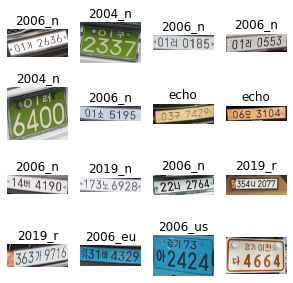

In [ ]:
fig = plt.figure(figsize=(5,5))

for index in range(16):

  title = predictions[index-1] # image title
  plt.title(title)   # title 
  plt.subplot(4,4, index+1)
  plt.imshow(img_list_np[index])
  plt.axis('off')

plt.show()  

In [ ]:
sample_img_path = "/content/drive/MyDrive/kmong/car_number/sample_data/"


sample_img_list = os.listdir(sample_img_path)
sample_img_list = sorted(sample_img_list)
sample_img_list = [os.path.join(sample_img_path, img) for img in sample_img_list]

In [ ]:
print(sample_img_list)

['/content/drive/MyDrive/kmong/car_number/sample_data/1996_n.jpg', '/content/drive/MyDrive/kmong/car_number/sample_data/2004_n.jpg', '/content/drive/MyDrive/kmong/car_number/sample_data/2006_eu.jpg', '/content/drive/MyDrive/kmong/car_number/sample_data/2006_n.jpg', '/content/drive/MyDrive/kmong/car_number/sample_data/2006_us.jpg', '/content/drive/MyDrive/kmong/car_number/sample_data/2019_n.jpg', '/content/drive/MyDrive/kmong/car_number/sample_data/2019_r.jpg', '/content/drive/MyDrive/kmong/car_number/sample_data/bike.jpg', '/content/drive/MyDrive/kmong/car_number/sample_data/echo.jpg']


In [ ]:
sample_img_list_np=[]

for i in sample_img_list:
    img = Image.open(i)
    img_array = np.array(img)
    sample_img_list_np.append(img_array)
    print(i, " 추가 완료 - 구조:", img_array.shape) # 불러온 이미지의 차원 확인 (세로X가로X색)
    #print(img_array.T.shape) #축변경 (색X가로X세로)

/content/drive/MyDrive/kmong/car_number/sample_data/1996_n.jpg  추가 완료 - 구조: (108, 174, 3)
/content/drive/MyDrive/kmong/car_number/sample_data/2004_n.jpg  추가 완료 - 구조: (88, 153, 3)
/content/drive/MyDrive/kmong/car_number/sample_data/2006_eu.jpg  추가 완료 - 구조: (92, 325, 3)
/content/drive/MyDrive/kmong/car_number/sample_data/2006_n.jpg  추가 완료 - 구조: (488, 1989, 3)
/content/drive/MyDrive/kmong/car_number/sample_data/2006_us.jpg  추가 완료 - 구조: (395, 766, 3)
/content/drive/MyDrive/kmong/car_number/sample_data/2019_n.jpg  추가 완료 - 구조: (451, 1183, 3)
/content/drive/MyDrive/kmong/car_number/sample_data/2019_r.jpg  추가 완료 - 구조: (277, 760, 3)
/content/drive/MyDrive/kmong/car_number/sample_data/bike.jpg  추가 완료 - 구조: (639, 1089, 3)
/content/drive/MyDrive/kmong/car_number/sample_data/echo.jpg  추가 완료 - 구조: (359, 1588, 3)


In [ ]:
print(predictions[0])

2006_n


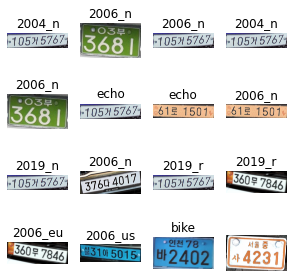

In [ ]:
fig = plt.figure(figsize=(5,5))




for index in range(16):
  clss = predictions[index]
  if clss == "1996_n":

    title = clss # image title
    plt.title(title)   # title 
    plt.subplot(4,4, index+1)
    plt.imshow(sample_img_list_np[0])
    plt.axis('off')

  elif clss == "2004_n":

    title = clss # image title
    plt.title(title)   # title 
    plt.subplot(4,4, index+1)
    plt.imshow(sample_img_list_np[1])
    plt.axis('off')


  elif clss == "2006_eu":

    title = clss # image title
    plt.title(title)   # title 
    plt.subplot(4,4, index+1)
    plt.imshow(sample_img_list_np[2])
    plt.axis('off')

  elif clss == "2006_n":

    title = clss # image title
    plt.title(title)   # title 
    plt.subplot(4,4, index+1)
    plt.imshow(sample_img_list_np[3])
    plt.axis('off')

  elif clss == "2006_us":

    title = clss # image title
    plt.title(title)   # title 
    plt.subplot(4,4, index+1)
    plt.imshow(sample_img_list_np[4])
    plt.axis('off')

  elif clss == "2019_n":

    title = clss # image title
    plt.title(title)   # title 
    plt.subplot(4,4, index+1)
    plt.imshow(sample_img_list_np[5])
    plt.axis('off')


  elif clss == "2019_r":

    title = clss # image title
    plt.title(title)   # title 
    plt.subplot(4,4, index+1)
    plt.imshow(sample_img_list_np[6])
    plt.axis('off')


  elif clss == "bike":

    title = clss # image title
    plt.title(title)   # title 
    plt.subplot(4,4, index+1)
    plt.imshow(sample_img_list_np[7])
    plt.axis('off')


  else:

    title = clss # image title
    plt.title(title)   # title 
    plt.subplot(4,4, index+1)
    plt.imshow(sample_img_list_np[8])
    plt.axis('off')


plt.show()  